# <span style='background-color: #fff5b1'>오늘의 한 걸음  🚶🏽‍♂️: 경구약제 이미지 분류</span>

## Contexts

### 1. READY
    1-1 오늘의 Exp와 Rubric  
    1-2 사용하는 라이브러리  

### 2. GAME
    2-1. 데이터 읽어오기  
        2-1-1. 데이터 경로설정
        2-1-2. EDA
    2-2. 데이터 전처리  
    2-3. 모델 학습  
    2-4. 데이터 평가   

### 3. POTG
    3-1. 소감
    3-2. 어려웠던 점과 극복방안  
    3-3. 추후  

---


# 1. Ready
## 1-1. 오늘의 Exp와 Rubric

우리나라에서는 AI Hub 라는 웹페이지에서  
다양한 이미지를 제공하고 있다. 

이번에 우리가 다룰 데이터는 경구약제 이미지 데이터이다.
경구약 (삼켜서 먹는 알약) 제품 약 5000종의 사진이  
한 종류당 약 1250장.

도합 2백만 장의 약 사진 및 메타 데이터를 가지고 있다

자료 : <a href='https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=576'>AI_Hub : 경구약제 이미지 데이터</a>

시각장애인 혹은 사회적 약자들은 약을 섭취함에 있어서  
섭취를 혼동하거나 남용하는 문제와 직면한다.

이번 Exp 는 경구약제 약품을 분류하고 식별 결과를 안내할 수 있는 AI 분류기를 만드는 것이다!

우선 기술상의 문제로
1TB가 넘는 용량의 사진을 모두 이용하기에 부담이 커서  

Traininig data set 에 있는 1250장의 사진 데이터를 이용하기로 했다.

## 1-2. 사용하는 라이브러리

In [32]:
import os
import json
import glob
import pandas as pd
import imageio
import matplotlib.pyplot as plt

import warnings #경고 무시하는 라이브러리
warnings.filterwarnings(action='ignore')


# 2. GAME
## 2-1. 데이터 읽어오기

일단 어떤 meta data 가 있는지 직접 눈으로 확인해보았다.

In [5]:
combined = []


for json_file in glob.glob("./pills/pills_data/data/Training/label/pills_5000/TL_81/K-038884_json/K-038884_0_0_0_0_75_000_200.json") : 

    with open(json_file, "rb") as infile:

        combined.append(json.load(infile))


In [8]:
type(json_file)

str

In [6]:
combined

[{'images': [{'file_name': 'K-038884_0_0_0_0_75_000_200.png',
    'width': 976,
    'height': 1280,
    'imgfile': 'K-038884_0_0_0_0_75_000_200.png',
    'drug_N': 'K-038884',
    'drug_S': '정상알약',
    'back_color': '검은색 배경',
    'drug_dir': '앞면',
    'light_color': '전구색',
    'camera_la': 75,
    'camera_lo': 0,
    'size': 200,
    'item_seq': '201602513',
    'leng_long': '6.2',
    'leng_short': '6.2',
    'thick': '3.05',
    'id': 1,
    'dl_idx': '38883',
    'dl_mapping_code': 'K-038884',
    'dl_name': '에피나레정',
    'dl_name_en': 'Epinare Tab.',
    'img_key': 'http://connectdi.com/design/img/drug/1NOwp2F69E9.jpg',
    'dl_material': '에피나스틴염산염',
    'dl_material_en': 'Epinastine Hydrochloride',
    'dl_custom_shape': '정제, 저작정',
    'dl_company': '제이더블유신약(주)',
    'dl_company_en': 'Jw Shinyak',
    'di_company_mf': '삼천당제약(주)',
    'di_company_mf_en': 'Scd Pharm',
    'di_item_permit_date': '20160504',
    'di_class_no': '[01490]기타의 알레르기용약',
    'di_etc_otc_code': '전문의약품',
    'd

약에 대해 알려주는 많은 데이터가 있었지만,  
우리의 경우 이미지 분류를 할 것이기 떄문에  
연동된 이미지 경로와 이름만을 뽑아내려고 계획했다.

따라서 json 내부에 두 데이터를 뽑아 csv 파일로 만들어 저장했다.

## 2-2-1. 데이터 경로설정

In [69]:
PATH = './pills/pills_data/data/Training/label/pills_5000/TL_81/'

def save_csv(PATH, name):
    """
    지정한 경로의 경구약제 json 파일을
    name 이름으로 csv 저장

    Args:
        PATH (_str_): 초기 경로
        name (_str_): 이름
    """
    files = os.listdir(PATH)

    cnt = 0
    pills_df = pd.DataFrame({'file':[],
                                'dl_name':[]}) # DataFrame
    for file_name in files:
        json_path = os.listdir(PATH + file_name)

        for json_data in json_path:
            json_file =  glob.glob(PATH + file_name +'/'+ json_data )[0]
            with open(json_file, "rb") as infile:
                data = json.load(infile)
                file = data['images'][0]['file_name']
                dl_name = data['images'][0]['dl_name']
                pills_df = pills_df.append({'file':[file], 'dl_name':[dl_name]}, ignore_index=True)
    
    pills_df.to_csv(name)
    return

save_csv(PATH, 'label.csv')


In [98]:
df = pd.read_csv('label.csv')

#df = df.drop('name', axis=1).iloc[:,1:] # 값이 깨끗하게 안나올 경우
df


,file,dl_name
0,['K-038884_0_0_0_0_75_000_200.png'],['에피나레정']
1,['K-038884_0_0_0_0_75_020_200.png'],['에피나레정']
2,['K-038884_0_0_0_0_75_040_200.png'],['에피나레정']
3,['K-038884_0_0_0_0_75_060_200.png'],['에피나레정']
4,['K-038884_0_0_0_0_75_080_200.png'],['에피나레정']
...,...,...
9607,['K-039147_0_2_1_2_90_260_200.png'],['듀카브정30/10밀리그램']
9608,['K-039147_0_2_1_2_90_280_200.png'],['듀카브정30/10밀리그램']
9609,['K-039147_0_2_1_2_90_300_200.png'],['듀카브정30/10밀리그램']
9610,['K-039147_0_2_1_2_90_320_200.png'],['듀카브정30/10밀리그램']


## 2-2-2. EDA

용량 문제상 조금만 가져온 데이터에는  
어떤 약들이 얼마나 있는지 조사해 보았다.

In [144]:
num = len(df['dl_name'].unique())
print(f'총 {len(df)} 개의 이미지 안에 { num } 개의 약 종류 존재')

총 9612 개의 이미지 안에 24 개의 약 종류 존재


In [110]:
for i in df['dl_name'].unique():
    print(i[2:-2])

에피나레정
티아프란정
비오메틱스캡슐(바실루스리케니포르미스균)
바실리포미스캡슐
크라틴정 20mg
크라틴정 10mg
크라틴정 5mg
락토엔큐캡슐(바실루스리케니포르미스균)\xa0
아나그레캡슐 0.5mg
뮤코원캡슐(에르도스테인)
엘도민캡슐 300mg
비우미정 500mg/병
앤도민300프리미엄연질캡슐 300mg/PTP
엘도스인캡슐(에르도스테인)
라노펜세미정
뉴에르도테캡슐
리프레가캡슐 75mg
리셀톤캡슐 6.0mg
베아로탄정 50mg
베아투스정
피타로틴정 2mg
루키오정10밀리그램(몬테루카스트나트륨)
듀카브정30/5밀리그램
듀카브정30/10밀리그램


같은 약인데도
용량에 따라 종류를 다르게 설정하였다는 것을 볼 수 있다.

특히 `크라틴정` 같은 경우  
용량에 따라 20mg, 10mg, 5mg 으로 구분하였다.

그렇다면 용량이 다를 때의 알약 사진도 다를까?  
확인해보자

In [124]:

# 각 약 종류당 한 장씩의 이미지를 불러왔다.
def make_pills_one(df):
    """
    데이터프레임에서 약 종류별로 하나씩 가져오는 코드
    """
    
    pills_df = pd.DataFrame()
    num = len(df['dl_name'].unique()) #총 약의 갯수

    for idx in range(num): # 각 약마다 한 행씩 불러오기
        df2 = df[df['dl_name'] == df['dl_name'].unique()[idx]] # idx 번째 약 종류
        pills_df = pills_df.append(df2.iloc[0:1])

    return pills_df

pills_df = make_pills_one(df)
    

,file,dl_name
0,['K-038884_0_0_0_0_75_000_200.png'],['에피나레정']
216,['K-038890_0_0_0_0_75_000_200.png'],['티아프란정']
432,['K-038896_0_1_0_0_70_000_200.png'],['비오메틱스캡슐(바실루스리케니포르미스균)']
756,['K-038910_0_0_0_0_70_000_200.png'],['바실리포미스캡슐']
1080,['K-038912_0_0_0_0_75_000_200.png'],['크라틴정 20mg']
1296,['K-038913_0_0_0_0_75_000_200.png'],['크라틴정 10mg']
1512,['K-038914_0_0_0_0_75_000_200.png'],['크라틴정 5mg']
1728,['K-038927_0_0_0_0_70_000_200.png'],['락토엔큐캡슐(바실루스리케니포르미스균)\xa0']
2052,['K-038929_0_0_0_0_70_000_200.png'],['아나그레캡슐 0.5mg']
2376,['K-038954_0_2_0_0_70_000_200.png'],['뮤코원캡슐(에르도스테인)']


이미지마다 이름을 붙여주려 했으나  
matplotlib 라이브러리에서 한글 폰트 변경을 실패해  
다 ㅁㅁ 로 뜬다..

하여튼 각 종류별 그림은 다음과 같다.

In [180]:
# import matplotlib as mpl

# plt.rc('font', family='NanumGothic') # For Windows
# #한글 폰트를 어떻게 적용하는가 ㅠㅠ
# print(mpl.rcParams['font.family'])
# print(mpl.rcParams['font.size'])

['NanumGothic']
10.0


In [188]:
img_PATH

'./pills/pills_data/data/Training/img/pills_5000/TS_81/'

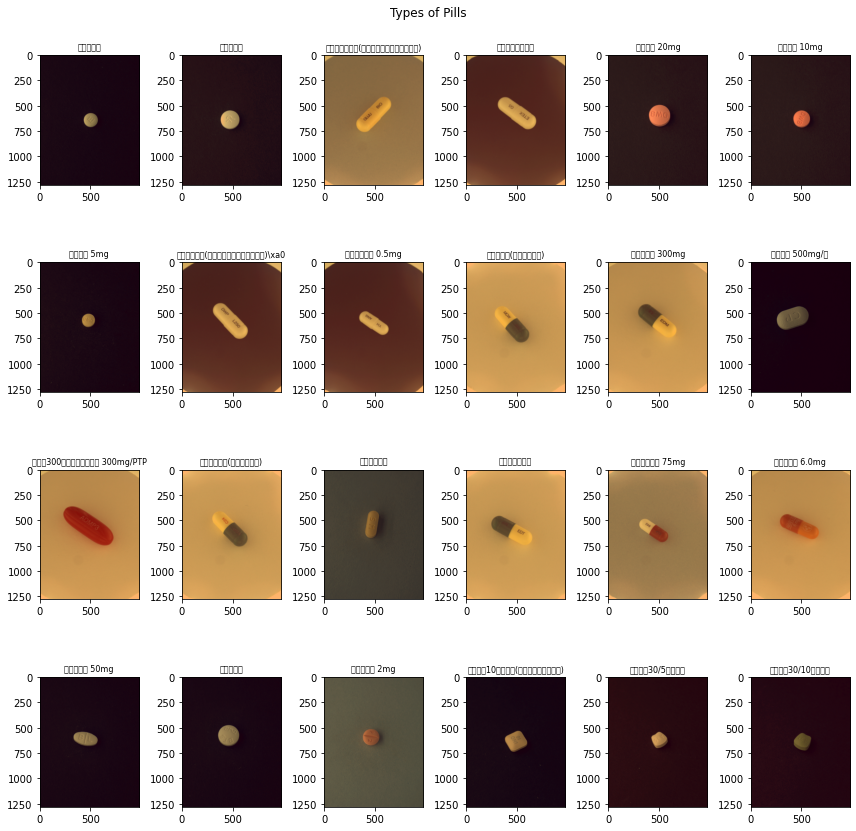

In [179]:

# 24 종의 약을 이미지화
def pills_img(pills_df):
    img_PATH = './pills/pills_data/data/Training/img/pills_5000/TS_81/'
    f, ax = plt.subplots(nrows=4,ncols=6, figsize=(12,12))

    idx = 0
    for i in range(4):
        for j in range(6):
        
            img = list(pills_df.iloc[:,0])[idx][2:-2]
            folder_1 = list(pills_df.iloc[:,0])[idx][2:10] #첫 폴더
            img_color = plt.imread(img_PATH + folder_1 + '/'+img)
            title = list(pills_df.iloc[:,1])[idx][2:-2]

            ax[i][j].imshow(img_color, resample=True)
            ax[i][j].set_title(title, fontsize=8)
            idx+=1
            
    plt.suptitle("Types of Pills")
    plt.tight_layout()
    plt.show()

pills_img(pills_df)

이미지를 통해 다음을 알 수 있다.

1. 모두 같은 크기의 이미지이다.
2. 용량에 따라 알약의 색과 크기도 변한다.
3. 크기만 다른 알약도 존재한다.

정말 크기만 다른지 알기 위해서  
크라틴정 삼총사를 들여다 보았다.

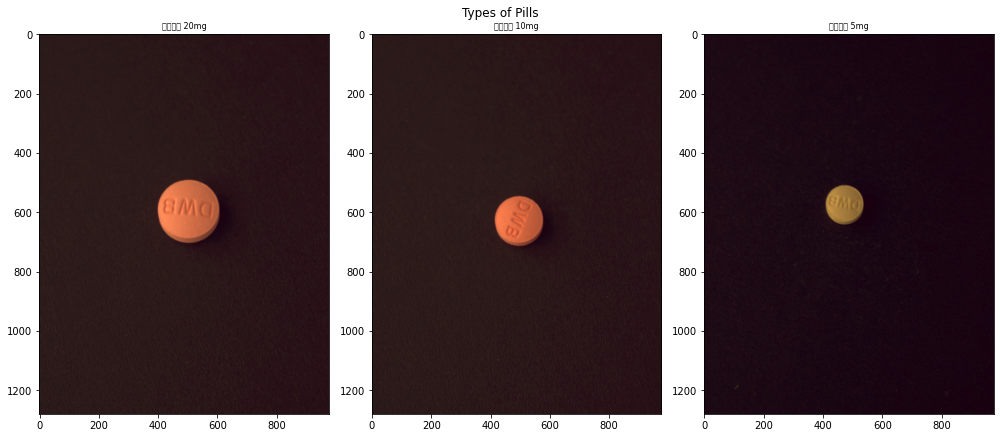

In [190]:


f, ax = plt.subplots(nrows=1,ncols=3, figsize=(14,6))

idx = 4
for i in range(3):
        
    img = list(pills_df.iloc[:,0])[idx][2:-2]
    folder_1 = list(pills_df.iloc[:,0])[idx][2:10] #첫 폴더
    img_color = plt.imread(img_PATH + folder_1 + '/'+img)
    title = list(pills_df.iloc[:,1])[idx][2:-2]

    ax[i].imshow(img_color, resample=True)
    ax[i].set_title(title, fontsize=8)
    idx+=1
            
plt.suptitle("Types of Pills")
plt.tight_layout()
plt.show()

아니 얘네는 너무 똑같잖아,, 싶었다.  
특히 10mg 과 20mg 은 정확하게 사이즈만 달랐다.  
허나 우리의 목표는 잘못된 약의 섭취를 막는 것이므로  

세 가지 용량의 크라틴정을 하나의 클래스로 취급하기로 결정했다.  

* 허나 용량의 차이를 우리가 주관적으로 간과하는 것은 큰 문제가 생길 것이므로 프로젝트 시에만 구분을 하지 않기로 한다.

## 2-2. 데이터 전처리

## 2-3. 모델 학습

## 2-4. 데이터 평가

# 3. POTG
## 3-1. 소감

## 3-2. 어려웠던 점과 극복방안

## 3-3. 추후